##미션 소개
- Hugging Face transformers 라이브러리를 사용하여 문서 요약 모델을 구현하는 미션입니다. 데이터 로드 및 전처리부터 요약 모델 실행, 결과 평가까지 전체 파이프라인을 구축해 보세요.

## 사용 데이터셋
- 데이터 형식:

 - JSON 파일 형태로 제공되며, 3종류(신문 기사, 사설, 법률)의 문서가 포함되어 있습니다.

- 데이터 구성:

 - 각 문서 타입은 train/test 쌍으로 구성되어 있으며, 전체 데이터를 모두 사용하거나 원하는 문서 종류를 선택하여 학습시키면 됩니다.

## 구글 드라이브에서 데이터 불러오기

In [7]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
zip_path = "/content/drive/MyDrive/코드잇/summarization.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## JSON 파일 구조 확인

In [ ]:
import os
import json
from pprint import pprint

folder_path = "/content/summarization"

for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        print(f"\n 파일: {filename}")

        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                print(f" - 타입: {type(data)}")
                print(f" - 길이: {len(data)}")
                print(f" - 샘플:")
                pprint(data[:1] if isinstance(data, list) else list(data.items())[:1])
            except Exception as e:
                print(f"  오류: {e}")


 파일: train_original_news.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '문서요약 프로젝트')]

 파일: train_original_editorial.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '사설/잡지 문서 프로젝트')]

 파일: valid_original_law.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '법률문서 프로젝트')]

 파일: valid_original_news.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '문서요약 프로젝트')]

 파일: valid_original_editorial.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '사설/잡지 문서 프로젝트')]

 파일: train_original_law.json
 - 타입: <class 'dict'>
 - 길이: 3
 - 샘플:
[('name', '법률문서 프로젝트')]


In [17]:
file_path = '/content/summarization/train_original_editorial.json'

In [18]:
import json

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [19]:
print(data.keys())

dict_keys(['name', 'delivery_date', 'documents'])


In [20]:
print(f"name 개수: {len(data['name'])}")
print(f"delivery_date 개수: {len(data['delivery_date'])}")
print(f"documents 개수: {len(data['documents'])}")

name 개수: 13
delivery_date 개수: 19
documents 개수: 56760


In [22]:
from pprint import pprint
pprint(data['documents'][:1])

[{'abstractive': ['이명박 대통령은 어제 30대 그룹 총수를 모아놓고 시대적 요구는 역시 총수가 앞장서야 한다고 발언하며 '
                  '기부문화 확산을 은근히 강조했으나 대통령의 강요나 포퓰리즘에 의한 압박보다는 자발적 문화로 구축해야 효과가 '
                  '더 큰 법으로 방안 마련을 맡기고 시간을 줘야 할 것으로 보인다.'],
  'annotator_id': 3924,
  'category': '오피니언',
  'char_count': '1153',
  'document_quality_scores': {'accurate': 3,
                              'informative': 3,
                              'readable': 4,
                              'trustworthy': 3},
  'extractive': [0, 6, 7],
  'id': '100062073',
  'media_name': '매일경제',
  'media_sub_type': '경제지',
  'media_type': 'online',
  'publish_date': '2011-09-01 00:03:01',
  'size': 'medium',
  'text': [[{'highlight_indices': '9,11;37,39;53,55;91,93;104,106',
             'index': 0,
             'sentence': '이명박 대통령이 어제 30대 그룹 총수를 모아놓고 "시대적 요구는 역시 총수가 앞장서야 한다. '
                         '이미 상당한 변화의 조짐이 있다는 것을 고맙게 생각한다. 총수들께서 직접 관심을 가져주시면 '
                         '빨리 전파돼 긍정적인 평가를 받을 수 있다고 본다"고 말했다.'},
            {'highligh

파일 목록
- train_original_news.json
- train_original_editorial.json
- train_original_law.json
- valid_original_news.json
- valid_original_editorial.json
- valid_original_law.json


Json 항목 구조 분석
- 파일 타입 : dict
- 길이 3 / dict_keys(['name', 'delivery_date', 'documents'])

- documents
 - abstractive : 사람이 직접 쓴 요약문 / 요약 정답 (label)
 - text : 본문 (여러개의 sentence로 구성)
 - char_count : 전체 본문에 등장한 모든 문자의 개수

## 데이터 분포 확인


 editorial
 - Q1: 17.00
 - Q3: 25.00
 - IQR: 8.00
 - 이상치 기준: 5.00 이하 / 37.00 이상
 - 이상치 개수: 1588 / 56760

 law
 - Q1: 5.00
 - Q3: 12.00
 - IQR: 7.00
 - 이상치 기준: 0.00 이하 / 22.50 이상
 - 이상치 개수: 1371 / 24329

 news
 - Q1: 10.00
 - Q3: 17.00
 - IQR: 7.00
 - 이상치 기준: 0.00 이하 / 27.50 이상
 - 이상치 개수: 8226 / 243983

 카테고리별 통계 요약:
    category  num_documents  total_sentences  avg_sentences_per_doc  \
0  editorial          56760          1213671              21.382505   
1        law          24329           241761               9.937153   
2       news         243983          3495621              14.327314   

   num_outliers  lower_bound  upper_bound  
0          1588          5.0         37.0  
1          1371          0.0         22.5  
2          8226          0.0         27.5  


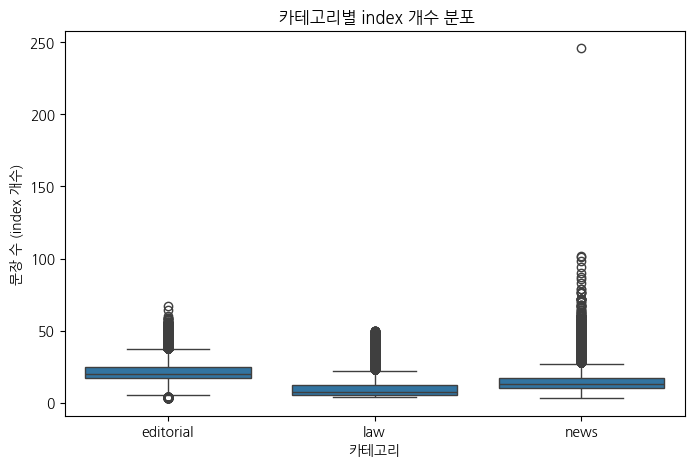

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 파일 경로 설정
base_path = "/content/summarization"
file_category_map = {
    "train_original_editorial.json": "editorial",
    "train_original_law.json": "law",
    "train_original_news.json": "news"
}

# 결과 저장용
category_stats = {
    "category": [],
    "num_documents": [],
    "total_sentences": [],
    "avg_sentences_per_doc": [],
    "num_outliers": [],
    "lower_bound": [],
    "upper_bound": []
}
index_distribution = []

# 파일별 반복
for file_name, category in file_category_map.items():
    file_path = os.path.join(base_path, file_name)

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if isinstance(data, dict) and 'documents' in data:
        data = data['documents']

    # 문서 수 및 문장 수 집계
    sentence_counts = [
        sum(len(para) for para in doc['text'])
        for doc in data
    ]
    total_sentences = sum(sentence_counts)
    avg_sentences = total_sentences / len(sentence_counts)
    num_docs = len(sentence_counts)

    # 이상치 기준 계산
    series = pd.Series(sentence_counts)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, 0)
    upper_bound = Q3 + 1.5 * IQR
    num_outliers = sum((series < lower_bound) | (series > upper_bound))

    # 이상치 기준 출력
    print(f"\n {category}")
    print(f" - Q1: {Q1:.2f}")
    print(f" - Q3: {Q3:.2f}")
    print(f" - IQR: {IQR:.2f}")
    print(f" - 이상치 기준: {lower_bound:.2f} 이하 / {upper_bound:.2f} 이상")
    print(f" - 이상치 개수: {num_outliers} / {len(series)}")

    # 통계 저장
    category_stats["category"].append(category)
    category_stats["num_documents"].append(num_docs)
    category_stats["total_sentences"].append(total_sentences)
    category_stats["avg_sentences_per_doc"].append(avg_sentences)
    category_stats["num_outliers"].append(num_outliers)
    category_stats["lower_bound"].append(lower_bound)
    category_stats["upper_bound"].append(upper_bound)

    # 분포 저장 (시각화용)
    for count in sentence_counts:
        index_distribution.append({
            "category": category,
            "index_count": count
        })

#  통계 출력
df_stats = pd.DataFrame(category_stats)
print("\n 카테고리별 통계 요약:")
print(df_stats)

#  index 개수 분포 시각화
df_index = pd.DataFrame(index_distribution)

plt.figure(figsize=(8, 5))
sns.boxplot(x="category", y="index_count", data=df_index)
plt.title(" 카테고리별 index 개수 분포")
plt.ylabel("문장 수 (index 개수)")
plt.xlabel("카테고리")
plt.show()

## 이상치 제거

- document 당 sentence의 수를 기준으로 이상치를 제거
- 과도하게 긴 문장의 경우 어차피 입력 토큰 최대 길이에 맞게 잘려서 입력이되고 , 만약 중요한 문장이 뒤편에 있다면 모델의 학습에 방해가 될수 있으므로 미리 이상치 document를 제거함
- 이상치가 제거된 데이터를 새로운 json파일로 저장
 - filtered_train_original_editorial.json
 - filtered_train_original_law
 - filtered_train_original_news

In [23]:
import os
import json
import pandas as pd

# 설정
base_path = "/content/summarization"
output_path = "/content/summarization"
os.makedirs(output_path, exist_ok=True)

file_category_map = {
    "train_original_editorial.json": "editorial",
    "train_original_law.json": "law",
    "train_original_news.json": "news"
}

for file_name, category in file_category_map.items():
    file_path = os.path.join(base_path, file_name)

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if isinstance(data, dict) and "documents" in data:
        data = data["documents"]

    # 문서별 문장 수 계산
    sentence_counts = [sum(len(para) for para in doc["text"]) for doc in data]

    # IQR 이상치 기준
    series = pd.Series(sentence_counts)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, 0)
    upper_bound = Q3 + 1.5 * IQR

    #  이상치 제거
    filtered_data = [
        doc for doc, count in zip(data, sentence_counts)
        if lower_bound <= count <= upper_bound
    ]

    #  저장
    output_file = os.path.join(output_path, f"filtered_{file_name}")
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(filtered_data, f, ensure_ascii=False, indent=2)

    print(f" {category}: {len(filtered_data)} / {len(data)} 문서 유지됨 (이상치 제거 완료)")

 editorial: 55172 / 56760 문서 유지됨 (이상치 제거 완료)
 law: 22958 / 24329 문서 유지됨 (이상치 제거 완료)
 news: 235757 / 243983 문서 유지됨 (이상치 제거 완료)


## json -> tsv -> dataset
- 원본 JSON 파일은 문서 1건당 다양한 필드(text, abstractive, category, document_quality_scores 등)를 포함하는 중첩된 구조로 되어 있어, 직접 학습에 사용하기 어려움
- 따라서 실제 학습에 필요한 source(원문)와 target(요약문) 필드만 추출하여 TSV 형식의 전처리 데이터로 변환

- 이후 Huggingface의 datasets 라이브러리를 통해 TSV 파일을 Dataset 객체로 불러와 학습 파이프라인과 연계

- editoral / law / news 에서 각각 20000개의 data random sampling -> tsv로 변환
- train_editorial.tsv + train_law.tsv + train_news.tsv = train_all.tsv


In [25]:
import json
import random
import csv
import os

def sample_and_save_tsv(json_path, sample_count, output_path):
    # Load JSON data
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Shuffle and sample
    random.shuffle(data)
    sampled = data[:sample_count]

    rows = []

    for doc in sampled:
        abstractive = doc.get("abstractive", [])
        if not abstractive:
            continue

        # Join all sentences into one document string
        source = " ".join(
            sentence_obj["sentence"]
            for paragraph in doc["text"]
            for sentence_obj in paragraph
        ).strip()

        target = abstractive[0].strip()

        if source and target:
            rows.append([source, target])

    # Save to TSV
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(["source", "target"])
        writer.writerows(rows)

    print(f"[{output_path}] 저장 완료! {len(rows)}개의 데이터 생성됨.")

# 경로 및 설정
datasets = [
    {
        "name": "editorial",
        "json_path": "/content/summarization/filtered_train_original_editorial.json",
        "output_path": "/content/summarization/train_editorial.tsv",
        "sample_count": 20000
    },
    {
        "name": "law",
        "json_path": "/content/summarization/filtered_train_original_law.json",
        "output_path": "/content/summarization/train_law.tsv",
        "sample_count": 20000
    },
    {
        "name": "news",
        "json_path": "/content/summarization/filtered_train_original_news.json",
        "output_path": "/content/summarization/train_news.tsv",
        "sample_count": 20000
    },
]

# 실행
for d in datasets:
    sample_and_save_tsv(d["json_path"], d["sample_count"], d["output_path"])

[/content/summarization/train_editorial.tsv] 저장 완료! 19999개의 데이터 생성됨.
[/content/summarization/train_law.tsv] 저장 완료! 20000개의 데이터 생성됨.
[/content/summarization/train_news.tsv] 저장 완료! 20000개의 데이터 생성됨.


In [26]:
def merge_tsv_files(input_paths, output_path):
    with open(output_path, 'w', encoding='utf-8', newline='') as out_f:
        writer = csv.writer(out_f, delimiter='\t')
        writer.writerow(["source", "target"])  # header

        for path in input_paths:
            with open(path, 'r', encoding='utf-8') as in_f:
                reader = csv.reader(in_f, delimiter='\t')
                next(reader)  # skip header
                for row in reader:
                    writer.writerow(row)

    print(f"[{output_path}] 통합 완료!")

# 사용 예시
merge_tsv_files(
    [
        "/content/summarization/train_editorial.tsv",
        "/content/summarization/train_law.tsv",
        "/content/summarization/train_news.tsv"
    ],
    "/content/summarization/train_all.tsv"
)

[/content/summarization/train_all.tsv] 통합 완료!


## tsv파일 확인

In [27]:
tsv_path = "/content/summarization/train_all.tsv"

with open(tsv_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(f"헤더: {line.strip()}")
            print("-" * 80)
        else:
            source, target = line.strip().split('\t')
            print(f"[{i}]  문서 (source): {source[:400]}...")
            print(f"     요약 (target): {target[:400]}...\n")
        if i > 5:
            break

헤더: source	target
--------------------------------------------------------------------------------
[1]  문서 (source): 일본 정부가 어제 독도 영유권 문제를 국제사법재판소(ICJ)에 제소하자고 우리 쪽에 제안한 것은 치밀한 각본에 따른 도발이다. 이명박 대통령 독도 방문과 일왕 사과 요구 발언 직후 마치 기다렸다는 듯이 치고 나온 것은 전방위적인 파상공세의 시작이라고 봐야 한다. 우리로서는 독도를 분쟁지역화하려는 일본의 간교한 술수에 말려들지 않도록 치밀한 전략을 갖고 대응해야 한다. 독도가 명백히 우리 땅이고 우리가 실효적인 지배를 하고 있으므로 우리가 ICJ 제소에 응할 까닭은 전혀 없다. 일본이 일방적으로 제소하더라도 우리가 받아들이지 않으면 재판은 불가능하다. 이미 1954년과 1962년 두 차례 ICJ 제소 제안을 했던 일본도 이 점을 알고 있다. 그런데도 50년 만에 다시 도발하고 나온 것은 국제사회에 독도 영유권...
     요약 (target): 일본 정부가 독도 영유권 문제를 국제사법재판소(ICJ)에 제소하자고 우리 쪽에 제안한 것은 치밀한 각본에 따른 도발로 간교한 술수에 말려들지 않도록 전략을 갖고 대응해야 하며 모든 가능성을 예상하고 시나리오별 대응전략을 가다듬어야 한다....

[2]  문서 (source): "예견됐던 바다. 자유한국당의 '5·18 망언'의원 처리가 소극적 차원을 넘어 유야무야될 거라는 점에 대해서다. 파문 당시 애써 당당함으로 맞서다 결국 여론에 떠밀려 '억지 춘향'격으로 당 윤리위원회를 소집해 징계 흉내만 내던 때부터 그랬다. 망언 세 의원 가운데 이종명 의원만 제명 처분을 내린 채 김진태, 김순례 의원의 결정은 미뤄두었다. 당 지도부를 꾸리는 전당대회 후보로 나섰다며 전당대회 이후 이들 의원에 대해 재논의하겠다는 거였다. 하지만 전당대회가 끝나고 들어선 황교안 체제는 이 문제를 처리할 생각이 별로 없는 듯 해 보인다. 이 의

- 검증데이터 카테고리별 2000개 random sampling

In [28]:
import json
import random
import csv
import os

def sample_json_to_tsv(json_path, sample_count, output_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data = data["documents"]  #  여기 수정!

    random.shuffle(data)
    sampled = data[:sample_count]
    rows = []

    for doc in sampled:
        abstractive = doc.get("abstractive", [])
        if not abstractive:
            continue
        source = " ".join(
            sentence_obj["sentence"]
            for paragraph in doc["text"]
            for sentence_obj in paragraph
        ).strip()

        target = abstractive[0].strip()

        if source and target:
            rows.append([source, target])

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(["source", "target"])
        writer.writerows(rows)

    print(f"[{output_path}] 저장 완료! {len(rows)}개 데이터 생성됨.")

# 각 valid JSON → 2000개씩 → 개별 TSV 저장
sample_json_to_tsv("/content/summarization/valid_original_editorial.json", 2000, "/content/summarization/val_editorial.tsv")
sample_json_to_tsv("/content/summarization/valid_original_law.json", 2000, "/content/summarization/val_law.tsv")
sample_json_to_tsv("/content/summarization/valid_original_news.json", 2000, "/content/summarization/val_news.tsv")

[/content/summarization/val_editorial.tsv] 저장 완료! 2000개 데이터 생성됨.
[/content/summarization/val_law.tsv] 저장 완료! 2000개 데이터 생성됨.
[/content/summarization/val_news.tsv] 저장 완료! 2000개 데이터 생성됨.


In [29]:
def merge_tsvs(input_paths, output_path):
    with open(output_path, 'w', encoding='utf-8', newline='') as out_f:
        writer = csv.writer(out_f, delimiter='\t')
        writer.writerow(["source", "target"])
        for path in input_paths:
            with open(path, 'r', encoding='utf-8') as in_f:
                reader = csv.reader(in_f, delimiter='\t')
                next(reader)  # skip header
                writer.writerows(reader)
    print(f"[{output_path}] 통합 완료!")

merge_tsvs(
    [
        "/content/summarization/val_editorial.tsv",
        "/content/summarization/val_law.tsv",
        "/content/summarization/val_news.tsv"
    ],
    "/content/summarization/val_all.tsv"
)

[/content/summarization/val_all.tsv] 통합 완료!


## tsv -> HuggingFace Dataset으로 변환

- train_all.tsv -> train_datset
- val_all.tsv -> val_dataset

In [30]:
import pandas as pd
from datasets import Dataset, DatasetDict

# TSV 불러오기
train_df = pd.read_csv("/content/summarization/train_all.tsv", sep="\t")
val_df = pd.read_csv("/content/summarization/val_all.tsv", sep="\t")

# HuggingFace Dataset으로 변환
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# 통합
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

## 사용한 모델 및 토크나이저
- 모델: gogamza/kobart-base-v1 (BART 기반 한국어 요약 사전학습 모델)
- 구조: Encoder-Decoder (Seq2Seq) 구조 사용
- 토크나이저: BartTokenizerFast
 - 동일한 checkpoint에서 불러옴
 - Fast Tokenizer로 속도 및 정확도 우수

In [ ]:
from transformers import BartTokenizerFast, BartForConditionalGeneration

checkpoint = "gogamza/kobart-base-v1"
tokenizer = BartTokenizerFast.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BartTokenizerFast'.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


- 모델 학습을 위해 원문(source)과 요약문(target)을 Transformer 모델에 맞게 토크나이즈
-  Huggingface의 tokenizer를 사용하여 input_ids와 labels를 생성
- 원문은 최대 512 토큰, 요약문은 최대 256 토큰으로 잘라내고, 부족한 길이는 padding='max_length'로 채워 정규화

In [ ]:
def preprocess(example):
    model_inputs = tokenizer(
        example["source"],
        max_length=512,
        padding="max_length",
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["target"],
            max_length=256,
            padding="max_length",
            truncation=True
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/59997 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

## KoBART의 구조적 한계를 고려하여 과도하게 긴 문장을 필터링
- KoBART는 원래 Facebook BART 모델 구조를 기반으로 만들어졌고, BART 구조의 Encoder와 Decoder는 기본적으로 512개의 위치 임베딩(position embedding)을 가지고 있음
- 즉, 토큰 수가 513 이상이면 더 이상 포지션 정보를 부여할 수 없음
- 따라서 원문이 512토큰보다 길면 잘리는 현상이 생기기 때문에 한번더 토큰화된 dataset의 토큰 길이 분포를 확인


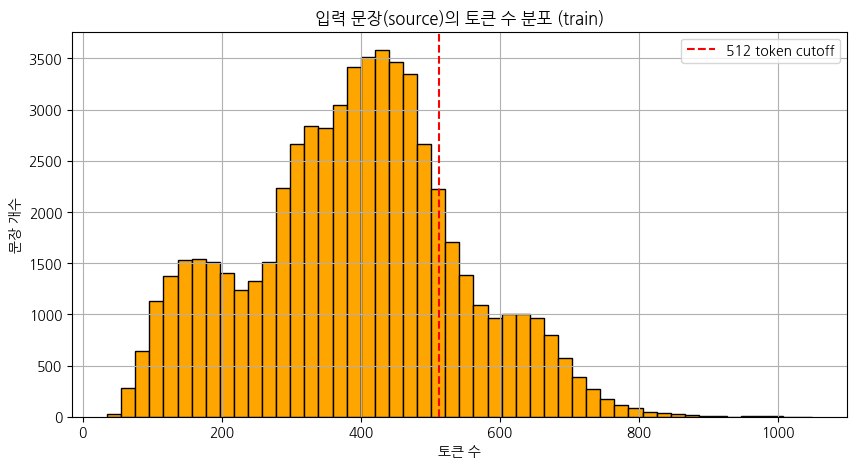

In [ ]:
# 토크나이저 기준 토큰 길이 분포 확인
train_df["source_len_token"] = train_df["source"].apply(lambda x: len(tokenizer.tokenize(x)))
val_df["source_len_token"] = val_df["source"].apply(lambda x: len(tokenizer.tokenize(x)))

# 시각화
plt.figure(figsize=(10, 5))
plt.hist(train_df["source_len_token"], bins=50, color="orange", edgecolor="black")
plt.axvline(x=512, color='red', linestyle='--', label='512 token cutoff')
plt.title("입력 문장(source)의 토큰 수 분포 (train)")
plt.xlabel("토큰 수")
plt.ylabel("문장 개수")
plt.legend()
plt.grid(True)
plt.show()

- tokenizer.tokenize(example["source"])를 통해 토큰 수를 계산하고,
길이가 512 이하인 경우에만 학습에 포함되도록 datasets.filter() 함수를 사용하여 사전 필터링을 수행
- 이후 preprocess() 함수를 정의하거나 재사용하여,
필터링된 데이터셋에 대해 Huggingface의 .map() 함수를 이용해 토크나이징 및 라벨 구성을 수행

In [ ]:
def is_token_length_ok(example):
    return len(tokenizer.tokenize(example["source"])) <= 512

# filter 적용 (train / validation에 각각)
filtered_dataset = dataset.filter(is_token_length_ok)

tokenized_dataset = filtered_dataset.map(preprocess, batched=True)

Filter:   0%|          | 0/59997 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/48378 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map:   0%|          | 0/5034 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


## 평가 지표
- rouge
- compute_metrics() 함수는 모델이 생성한 요약 결과와 정답 요약을 각각 디코딩한 후, Huggingface의 rouge.compute() 함수를 통해 ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum의 F1 score를 계산한다.
- use_stemmer=True 옵션을 통해 어형 차이를 줄이고 보다 일반화된 평가가 가능하도록 설정

- ROUGE-1은 단어 단위의 중복률로, 핵심 키워드가 얼마나 잘 반영되었는지를 측정한다.

- ROUGE-2는 2-gram 단위로 문맥적 연결성과 표현의 자연스러움을 평가한다.

- ROUGE-L은 가장 긴 공통 부분 문자열(Longest Common Subsequence)을 기반으로 문장 구조 유사도를 계산한다.

- ROUGE-Lsum은 다중 문장 요약을 위한 확장 지표로, 전체 문단 흐름과 문장 간 연결성을 평가하는 데 적합하다.

In [ ]:
!pip install rouge_score

In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: v.mid.fmeasure for k, v in result.items()}

In [ ]:
!pip install -U transformers

## 학습 및 검증 (Fine-tuning)
- KoBART 전체 레이어를 파인튜닝
- 학습 및 검증은 Huggingface의 Seq2SeqTrainer 클래스를 사용하여 수행
- 학습 파라미터 : training_args
- predict_with_generate=True : 통해 모델이 직접 요약을 생성하여 평가

In [36]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}  학습됨")
    else:
        print(f"{name}  고정됨 (freeze)")

model.shared.weight  학습됨
model.encoder.embed_positions.weight  학습됨
model.encoder.layers.0.self_attn.k_proj.weight  학습됨
model.encoder.layers.0.self_attn.k_proj.bias  학습됨
model.encoder.layers.0.self_attn.v_proj.weight  학습됨
model.encoder.layers.0.self_attn.v_proj.bias  학습됨
model.encoder.layers.0.self_attn.q_proj.weight  학습됨
model.encoder.layers.0.self_attn.q_proj.bias  학습됨
model.encoder.layers.0.self_attn.out_proj.weight  학습됨
model.encoder.layers.0.self_attn.out_proj.bias  학습됨
model.encoder.layers.0.self_attn_layer_norm.weight  학습됨
model.encoder.layers.0.self_attn_layer_norm.bias  학습됨
model.encoder.layers.0.fc1.weight  학습됨
model.encoder.layers.0.fc1.bias  학습됨
model.encoder.layers.0.fc2.weight  학습됨
model.encoder.layers.0.fc2.bias  학습됨
model.encoder.layers.0.final_layer_norm.weight  학습됨
model.encoder.layers.0.final_layer_norm.bias  학습됨
model.encoder.layers.1.self_attn.k_proj.weight  학습됨
model.encoder.layers.1.self_attn.k_proj.bias  학습됨
model.encoder.layers.1.self_attn.v_proj.weight  학습됨
mod

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, GenerationConfig

training_args = Seq2SeqTrainingArguments(
    output_dir="./kobart_results",  # 모델 저장 디렉토리
    per_device_train_batch_size=8, # 학습 배치 사이즈
    per_device_eval_batch_size=8,  # 검증 배치 사이즈
    num_train_epochs=2,  # 학습 epoch 수
    logging_dir="./logs",  # 로그 저장 위치
    logging_steps=500,   # 로그 출력 주기
    eval_strategy="steps",   # 평가 방식 (step 단위 평가)
    eval_steps=500,  # 500 step마다 평가
    save_strategy="steps",  # 500 step마다 평가
    save_steps=500,  # 500 step마다 모델 저장
    save_total_limit=2, # 체크포인트 최대 2개만 저장
    predict_with_generate=True, # 요약 생성 활성화 (generate 사용)
    load_best_model_at_end=True,  # 최종적으로 가장 성능 좋은 모델 로드
    metric_for_best_model="rougeL",  # "가장 좋은 모델" 기준: ROUGE-L
)

trainer = Seq2SeqTrainer(
    model=model,  # KoBART 사전학습 모델
    args=training_args, # 위에서 정의한 학습 설정
    train_dataset=tokenized_dataset["train"],  # 학습 데이터셋
    eval_dataset=tokenized_dataset["validation"], # 검증 데이터셋
    tokenizer=tokenizer,  # 토크나이저
    compute_metrics=compute_metrics # 평가 함수 (ROUGE 계산)
)

/tmp/ipython-input-18-887659087.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: daeseok900 (daeseok900-codeit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,0.718400,0.377580,0.216644,0.074407,0.213798,0.213655
1000,0.395500,0.366329,0.226960,0.079791,0.222945,0.222796
1500,0.380100,0.357236,0.240013,0.086394,0.235695,0.235872
2000,0.368500,0.348373,0.238938,0.084294,0.233984,0.234172
2500,0.368100,0.349870,0.234720,0.083564,0.230348,0.230549
3000,0.366900,0.341510,0.229429,0.079701,0.225548,0.225494
3500,0.357200,0.338494,0.238369,0.086499,0.233516,0.233625
4000,0.354400,0.335228,0.234901,0.082848,0.230073,0.230120
4500,0.355100,0.333812,0.229414,0.081533,0.224763,0.224753
5000,0.348100,0.331256,0.231150,0.083736,0.226832,0.227139


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'forced_eos_token_id': 1}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=12096, training_loss=0.3405563380352404, metrics={'train_runtime': 9489.0418, 'train_samples_per_second': 10.197, 'train_steps_per_second': 1.275, 'total_flos': 2.949783037673472e+16, 'train_loss': 0.3405563380352404, 'epoch': 2.0})

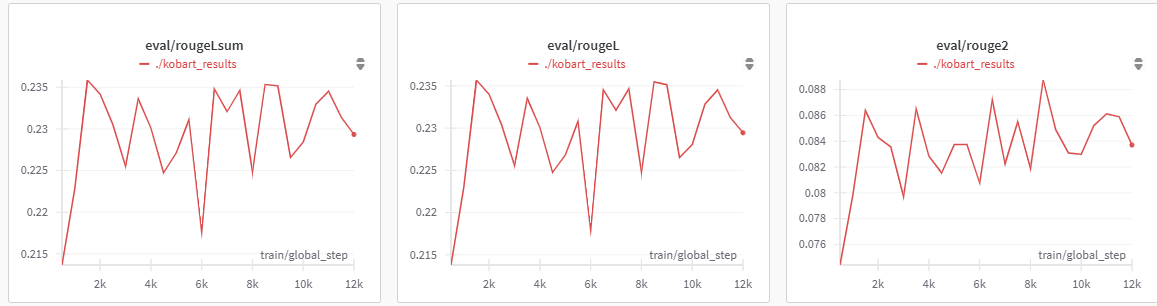

- Loss 변화
 - Training Loss는 초기에 0.71 → 점진적으로 0.28까지 감소
 - Validation Loss도 0.37 → 0.32 근처에서 안정화

- ROUGE 점수 변화
 - RougeL_sum을 기준으로 0.213655 에서 시작 최대 0.235168 까지 달성
 - 전반적으로 ROUGE 점수는 학습이 진행됨에 따라 소폭 상승하는 추세를 보였으나,
각 step별 성능에는 다소 변동폭이 존재

## 추론

In [ ]:
import random

# 1. 검증 데이터에서 랜덤으로 10개 샘플 인덱스 선택
sample_indices = random.sample(range(len(val_df)), 10)

# 2. 모델 디바이스 확인
device = next(model.parameters()).device

# 3. 반복하여 출력
for idx in sample_indices:
    # 입력 및 정답 문장
    sample_text = val_df.iloc[idx]["source"]
    reference_summary = val_df.iloc[idx]["target"]

    # 토크나이징 및 디바이스 이동
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 요약 생성
    summary_ids = model.generate(inputs["input_ids"], max_length=256, num_beams=4)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # 결과 출력
    print("=" * 80)
    print(f"[샘플 {idx}]")
    print(f"입력문장 : {sample_text}\n")
    print(f"출력문장 : {generated_summary}\n")
    print(f"정답문장 : {reference_summary}")
    print("=" * 80 + "\n")

[샘플 712]
입력문장 : 정부가 강남 4 구와 이른바 마용성(마포·용산·성동)을 중심으로 서울 27 개 동을 민간택지 분양가상한제 대상 지역으로 지정한 가운데 6 일 서울 남산에서 용산구와 서초구가 보이고 있다. 국토교통부가 어제 서울 지역 27 개 동을 민간택지 분양가 상한제 적용 지역으로 지정했다. 서울 강남 4 구와 마포·용산·성동구 지역이 대상에 올랐다. 분양가 상한제가 4 년7 개월 만에 부활했다. 이들 지역에서는 택지비·건축비에 적정 이윤을 보탠 가격을 산정한 뒤 그 이하로만 주택을 분양할 수 있다. 아파트 당첨자에게는 5∼10 년에 걸친 전매 제한과 2∼3 년의 실거주 의무가 주어진다. 일반 아파트는 8 일부터, 재개발·재건축 아파트는 내년 4 월29 일 이후 입주자 모집공고를 신청한 단지에 적용된다. 서울의 330 개 단지, 30 만 가구가 영향을 받는다고 한다. 가파르게 오르는 집값을 잡기 위한 조치다. 서울 강남권에선 3.3 ㎡당 1 억원이 넘는 아파트까지 등장했다. 국토부는 "지난 1 년간 서울의 분양가가 집값보다 4 배 이상 올랐다"고 규제 이유를 밝혔다. 시장의 가격결정 기능을 배제한 채 정부가 직접 가격 통제에 나선 것은 극약처방에 가깝다. 최근의 집값 상승은 저금리와 재정 방출에 따른 자산가격 상승의 측면이 강하다. 일부 투기수요가 있는 것도 사실이지만 근본적으로는 이런 흐름을 배경으로 한다. 분양가를 낮춘다고 집값이 잡힐지는 미지수다. 오히려 부작용을 우려하는 목소리가 크다. 동 단위로 규제함으로써 기존 아파트와 주변 집값을 끌어올리는 '풍선 효과'가 나타날 가능성이 있다. 분양가 규제로 주택공급은 더욱 위축되고, 공급 축소가 다시 집값을 상승시키는 악순환이 발생할 수도 있다. '로또 아파트'를 양산할 것이라는 주장도 나온다. 국토부는 "그래도 집값이 잡히지 않으면 정책수단을 총동원하겠다"고 했다. 규제가 규제를 부르는 '규제 블랙홀' 사태가 벌어질 판이다. 정작 심각한 문제는 정부 스스로 총선을 앞두고 집값 불안을 부추기는 선

## 샘플별 분석
- 712 : 입력문장의 앞부분을 그대로 가져와서 문장 뒷부분의 중요 정보를 하나도 제대로 요약하지 못함
- 4837 : 입력문장의 앞부분을  필요한 부분만 가져와서 잘 요약했으나 어떻게 처리했다는 내용을 요약하지못함 (시교육청은 재고납품 업체에게 신상품 교환과 가격할인을 요청하고 납품기한을 지키지 않은 업체에는 지연배상금을 청구하기로 결정했다.)
- 3456 : 문장이 거의 압축이 되지 않음
- 767 : 요약이 괜찮게 됨

## 전체적인 평가
- 문서 초반 위주 요약 경향
- 요약이 거의되지 않은 출력을 만드는 경우를 보았을때 요약 능력에서도 아쉬움이 있음
- 사실 전달 / 정보 전달을 부분적으로 하는 경향이 있고, 문서가 길어질수록 결론적 논지나 비판을 반영하지 못하는 경향이 있음
- KoBART(base)는 약 110M(1억개) 이상의 파라미터를 가짐 . 이에 비해 학습데이터 5만 개는 이 수에 비해 데이터 크기가 상대적으로 적은 편으로 , 전체 레이어 학습을 수행한 실험에서는 오버피팅 가능성도 배제하기 어려움

## 개선을 위해 추가로 시도해볼 만한 실험

- 학습 데이터의 입력문장을 살펴보고 일반적으로 앞 부분에 중요한 부분이 많았는지 확인
-  Label Smoothing 추가
- PEFT (Parameter-Efficient Fine-Tuning) 사용